In [2]:
from shared.preface import *
import shared.functions as fct

### Coordinates of Andromeda (AG) and the Virgo Cluster (VC).

In [6]:
# Cross-check with values in Mertsch et al. (2020).
# -> x and y coords. are switched, since our setup is different,
# and my x (their y) coords. differ by 8.5 kpc due to placement of sun
# on our x-axis.
coords_VC = fct.halo_pos(GLAT_VC, GLON_VC, DIST_VC/kpc)
print(coords_VC, 'in kpc')
coords_AG = fct.halo_pos(GLAT_AG, GLON_AG, DIST_AG/kpc)
print(coords_AG, 'in kpc')

[-4289.63477282  1056.51861602 15895.27621304] in kpc
[ 632.29742673 -377.40315121 -288.27006757] in kpc


### Values in Table 1 of Mertsch et al. (2020).

In [ ]:
Rvir_Tab1 = fct.R_vir(0, Mvir_MW)
print(Rvir_Tab1/kpc)
c_vir_Tab1 = fct.c_vir(0, Mvir_MW, Rvir_MW, Rs_MW)
Rs_Tab1 = Rvir_Tab1 / c_vir_Tab1
print(Rs_Tab1/kpc)

### Critical density of universe.

In [ ]:
rho_crit_today = fct.rho_crit(0)
print(f'{rho_crit_today*(Msun/kpc**3)/(kg/m**3):.2e} kg/m^3') 

### Time Variable s(z) and comparison to age of universe.

In [ ]:
# In s_of_z function we use
H0_mod = H0/ (1/s)
print(H0_mod)

test_z = 1
s_val = fct.s_of_z(test_z)
print(f'Value of time variable s in seconds at redhshift {test_z}:','\n', s_val)
print('Age of universe in seconds:','\n', t0/s, 1/H0/s)

### Integrals for cosmic time.

In [ ]:
def t_integrand_a(a):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M/a**3 + Omega_L)*H0_val*a
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_a, 0, 1)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

In [ ]:
def t_integrand_z(z):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M*(1.+z)**3 + Omega_L)*H0_val*(1.+z)
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_z, 0, np.inf)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

### Fermi-Dirac distribution.

In [ ]:
p_test_range = np.linspace(0.01, 10)*T_CNB
FD_range = fct.Fermi_Dirac(p_test_range)

plt.loglog(p_test_range/T_CNB, FD_range)
plt.show()

### Conversions between momentum and velocity (limits).

In [ ]:
for m_eV in NU_MASSES:

    # Momentum limits (in units of T_CNB) to velocity limits (in km/s).
    v_lower = LOWER/m_eV / (km/s)
    v_upper = UPPER/m_eV / (km/s)
    print(v_lower, v_upper)

    # Velocity limits (in km/s) to momentum limits (in units of T_CNB).
    p_lower, y_lower = fct.u_to_p_eV(v_lower*(km/s)/(kpc/s), m_eV)
    p_upper, y_upper = fct.u_to_p_eV(v_upper*(km/s)/(kpc/s), m_eV)
    print(np.round(y_lower, 4), np.round(y_upper, 4), '\n')

### Redshift array for integration steps.

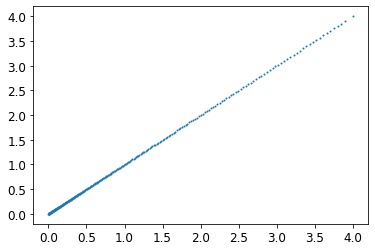

[0.         0.00124557 0.00250666 0.00378345 0.00507615 0.00638495
 0.00771005 0.00905166 0.01040998 0.01178521] 4.0


In [10]:
# Linear spacing.
# late_steps = 200
# early_steps = 100
# Z_START, Z_STOP, Z_AMOUNT = 0., 4., late_steps+early_steps
# z_late = np.linspace(0,1,late_steps)
# z_early = np.linspace(1.01,4,early_steps)
# ZEDS = np.concatenate((z_late, z_early))

# Logarithmic spacing.
Z_START, Z_STOP, Z_AMOUNT = 0., 4., 300-1  # -1 to compensate np.insert of z=4
Z_START_LOG = 1e-1
zeds_pre = np.geomspace(Z_START_LOG, Z_STOP, Z_AMOUNT) - Z_START_LOG
ZEDS = np.insert(zeds_pre, len(zeds_pre), 4.)

plt.scatter(ZEDS, ZEDS, s=1)
plt.show()
print(ZEDS[0:10], ZEDS[-1])